In [1]:
import pandas as pd

pd.options.display.max_rows = None #to display all rows of a dataframe in the jupyter notebook
pd.options.display.max_columns = None #to display all columns of a dataframe in the jupyter notebook
pd.set_option('display.max_colwidth',None) #to display all the content of a cell of a dataframe in the jupyter notebook

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to display multiple output in a single cell

import numpy as np
from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import itertools
from scipy.stats import kurtosis, skew, norm

import warnings
warnings.filterwarnings('ignore')

##### Lets check the train data.
##### 'Customer ID' and 'Name' has high cardinality hence we will drop these columns
##### In oder to differentiate the Train and Test data, we will add a new column 'Status' with two values 'Train' and 'Test'

In [2]:
df_train = pd.read_csv('train.csv')
df_train['Status'] = 'Train'
df_train.drop(columns = ['Customer ID', 'Name'], axis = 1, inplace = True)
df_train.head()

,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD),Status
0,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,241.08,N,N,3.0,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18,Train
1,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,495.81,N,Y,1.0,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98,Train
2,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,171.95,N,Y,1.0,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43,Train
3,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,298.54,N,Y,2.0,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54,Train
4,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,491.41,N,Y,NaN,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28,Train


In [4]:
df_train.tail()

,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD),Status
29995,M,38,4969.41,Low,Commercial associate,Managers,Urban,76657.90,722.34,Y,Y,2.0,869.61,0,Unpossessed,566,4969.41,4,Urban,1,111096.56,68992.11,Train
29996,M,20,1606.88,Low,Working,Laborers,Semi-Urban,66595.14,253.04,N,N,3.0,729.41,0,Inactive,175,1606.88,3,Urban,1,73453.94,46616.60,Train
29997,F,49,NaN,Low,Working,Sales staff,Urban,81410.08,583.11,N,Y,NaN,NaN,0,Active,959,NaN,1,Rural,1,102108.02,61057.56,Train
29998,M,38,2417.71,Low,Working,Security staff,Semi-Urban,142524.10,378.29,N,Y,3.0,677.27,1,Unpossessed,375,2417.71,4,Urban,1,168194.47,99766.87,Train
29999,F,63,3068.24,High,Pensioner,NaN,Rural,156290.54,693.94,N,Y,1.0,815.44,0,Active,344,3068.24,3,Rural,1,194512.60,117217.90,Train


##### Lets check the test data
##### Here also dropping the same columns

In [3]:
df_test = pd.read_csv('test.csv')
df_test['Status'] = 'Test'

CustomerId = df_test['Customer ID']
df_test.drop(columns = ['Customer ID', 'Name'], axis = 1, inplace = True)
df_test.head()

,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Status
0,F,47,3472.69,Low,Commercial associate,Managers,Semi-Urban,137088.98,396.72,N,N,2.0,799.14,0,Unpossessed,843,3472.69,2,Urban,1,236644.5,Test
1,F,57,1184.84,Low,Working,Sales staff,Rural,104771.59,463.76,Y,Y,2.0,833.31,0,Unpossessed,22,1184.84,1,Rural,1,142357.3,Test
2,F,52,1266.27,Low,Working,NaN,Semi-Urban,176684.91,493.15,N,Y,3.0,627.44,0,Unpossessed,1,1266.27,1,Urban,1,300991.24,Test
3,M,65,1369.72,High,Pensioner,NaN,Rural,97009.18,446.15,N,Y,2.0,833.20,0,Inactive,730,1369.72,1,Semi-Urban,0,125612.1,Test
4,F,60,1939.23,High,Pensioner,NaN,Urban,109980.00,370.10,N,N,NaN,NaN,0,NaN,356,1939.23,4,Semi-Urban,1,180908.0,Test


##### There are 22 independent features and 1 independent: 'Loan Sanction Amount (USD)'.
##### We have dataset of 30000 records

In [5]:
print(df_train.shape)

(30000, 23)


##### Merging the two dataframes

In [6]:
df_total= pd.concat([df_train,df_test],ignore_index = True)
df_total.shape

(50000, 23)

##### There are  some special character like '?' in test dataset. Most of these values are contained in column: ' Co-Applicant' & 'Property Price'

In [10]:
df_total[(df_total.values.ravel() == '?').reshape(df_total.shape).any(1)].shape
df_total[(df_total.values.ravel() == '?').reshape(df_total.shape).any(1)][['Co-Applicant','Property Price']].head()

(242, 23)

,Co-Applicant,Property Price
30022,1,?
30038,?,61214.55
30149,1,?
30304,?,47109.87
30318,?,244774.9


##### Replacing the '?' with NaN 

In [11]:
df_total.replace(to_replace ='?',value =np.nan,inplace = True)

##### Checking the data summary
#####  We have 11 categorical columns and 10 numerical columns and 1 target column

In [8]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Gender                       49916 non-null  object 
 1   Age                          50000 non-null  int64  
 2   Income (USD)                 44674 non-null  float64
 3   Income Stability             47504 non-null  object 
 4   Profession                   50000 non-null  object 
 5   Type of Employment           38041 non-null  object 
 6   Location                     50000 non-null  object 
 7   Loan Amount Request (USD)    50000 non-null  float64
 8   Current Loan Expenses (USD)  49745 non-null  float64
 9   Expense Type 1               50000 non-null  object 
 10  Expense Type 2               50000 non-null  object 
 11  Dependents                   46365 non-null  float64
 12  Credit Score                 47554 non-null  float64
 13  No. of Defaults 

##### univariate analysis

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:title={'center':'Type of Employment'}>

<Figure size 720x1080 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:title={'center':'Dependents'}>

<Figure size 720x1080 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:title={'center':'Has Active Credit Card'}>

<Figure size 720x1080 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:title={'center':'Income Stability'}>

<Figure size 720x1080 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:title={'center':'Property Location'}>

<Figure size 720x1080 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:title={'center':'Gender'}>

<Figure size 720x1080 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:title={'center':'No. of Defaults'}>

<Figure size 720x1080 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:title={'center':'Expense Type 2'}>

<Figure size 720x1080 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:title={'center':'Location'}>

<Figure size 720x1080 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:title={'center':'Property Type'}>

<Figure size 720x1080 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:title={'center':'Profession'}>

<Figure size 720x1080 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:title={'center':'Co-Applicant'}>

<Figure size 720x1080 with 0 Axes>

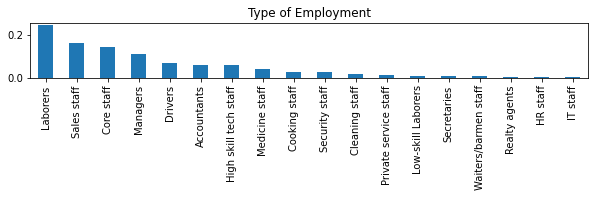

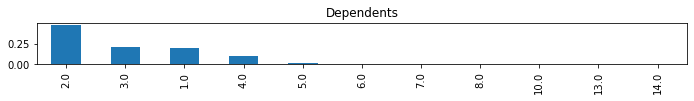

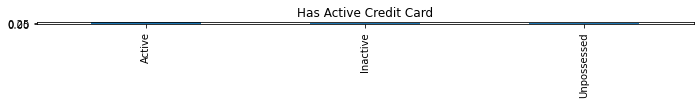

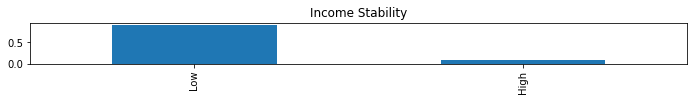

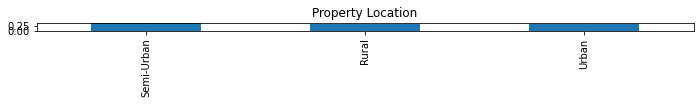

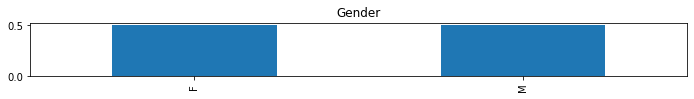

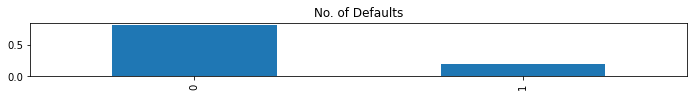

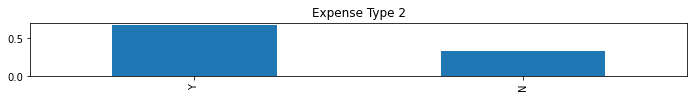

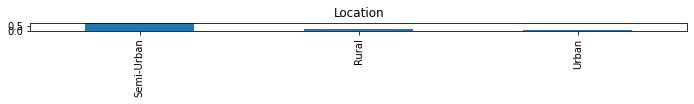

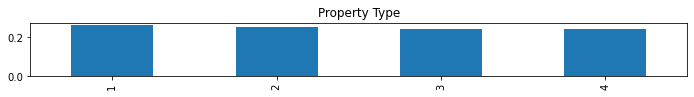

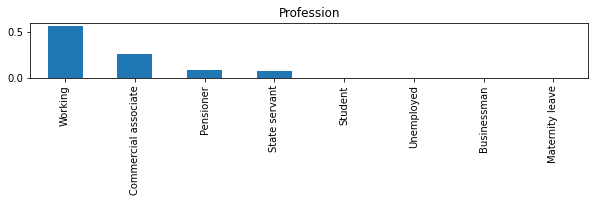

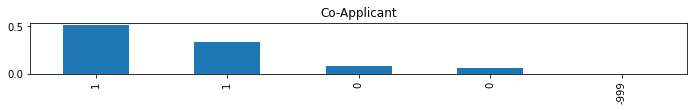

In [12]:
cols = ['Type of Employment', 'Dependents', 'Has Active Credit Card','Income Stability','Property Location','Gender'
       ,'No. of Defaults','Expense Type 2','Location','Property Type' ,'Profession','Co-Applicant' ]

row = 12
col = 1

plt.figure(figsize = (10,15))

for i,j in enumerate(cols,start =1):
    plt.figure(figsize = (10,15))
    plt.subplot(row,col,i)
    df_total[j].value_counts(normalize=True).plot(kind = 'bar', title = j)
    plt.subplots_adjust(top=0.85)
    plt.tight_layout(pad=2)
plt.show()

##### mutlivariate analysis

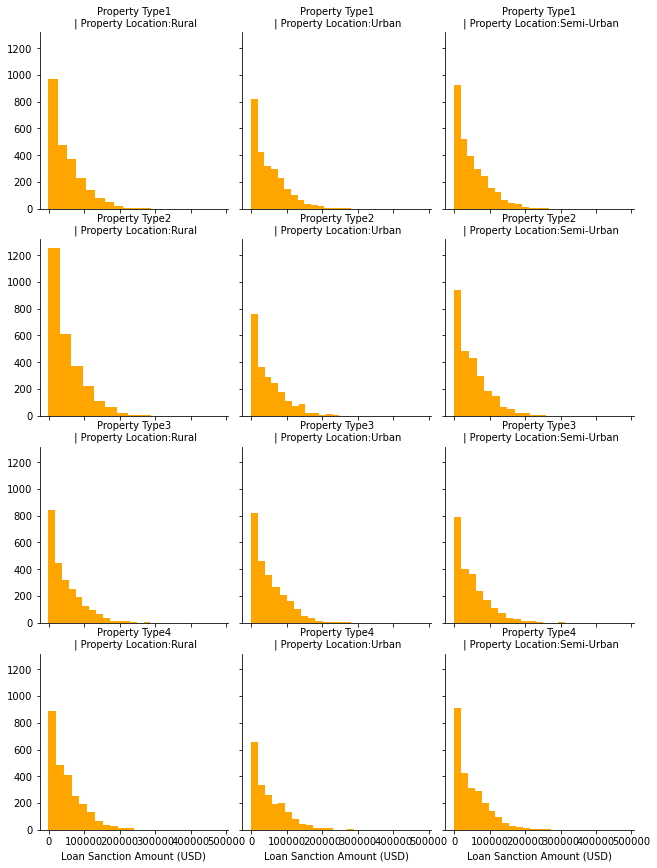

In [13]:
# We can see that Property type:2 is in demand more in Rural areas whose lonas are getting sanctioned easily

graph = sns.FacetGrid(df_total, row ='Property Type', col ='Property Location')

graph.map(plt.hist, 'Loan Sanction Amount (USD)', bins = 15, color ='orange')

graph.set_titles(row_template = 'Property Type{row_name}\n', col_template = 'Property Location:{col_name}')

plt.show()

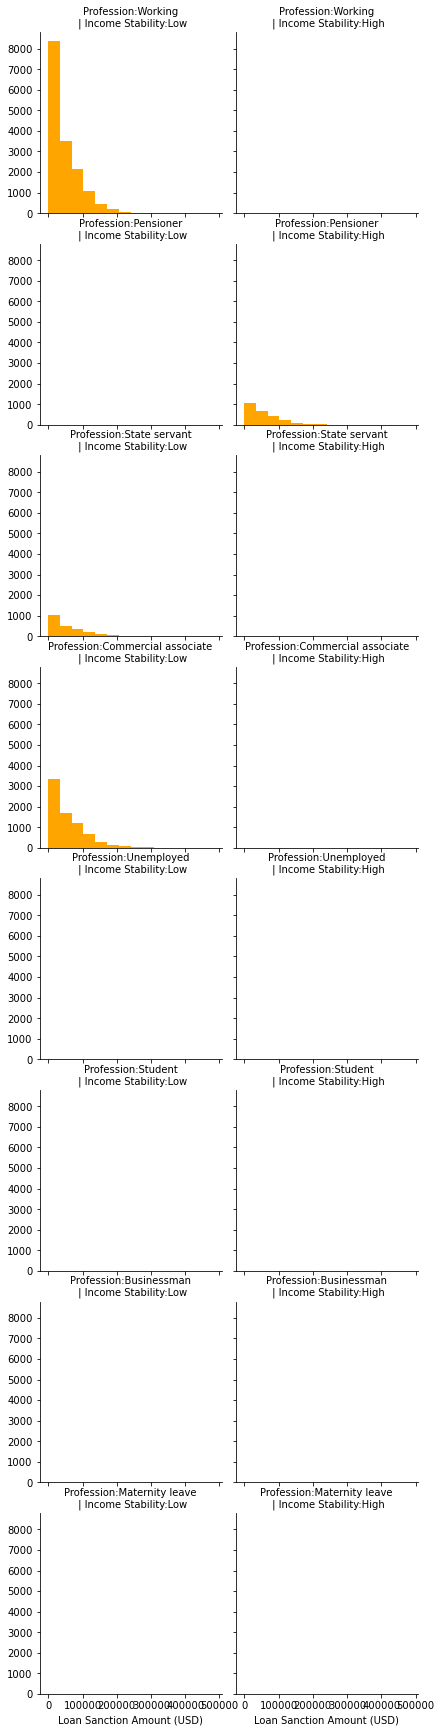

In [14]:
# 1. From this graph we see that only one profession: Pensioner has a High Income Stability which is justified as they
#    will get their monthyl pensions on time
# 2. Also we see that majority of the people with LOW income stability have profession: Working, Commercial associate.
# 3. Also we see that no loan is sanctioned to people who are students , unemployed which is justified cause 
#    they dont have any assest.

bins = np.linspace(df_total['Loan Sanction Amount (USD)'].min(), df_total['Loan Sanction Amount (USD)'].max(),15)

graph = sns.FacetGrid(df_total, row ='Profession', col ='Income Stability')

graph.map(plt.hist, 'Loan Sanction Amount (USD)', bins = bins, color ='orange')

graph.set_titles(row_template = 'Profession:{row_name}\n', col_template = 'Income Stability:{col_name}')

plt.show()

#### Lets plot the boxplot to check for outliers
##### But we are not going to remove any data

<Figure size 576x576 with 0 Axes>

<AxesSubplot:>

{'whiskers': [<matplotlib.lines.Line2D at 0x17fe8a58048>,
 'caps': [<matplotlib.lines.Line2D at 0x17fec12cd48>,
 'boxes': [<matplotlib.lines.Line2D at 0x17fec12c588>],
 'medians': [<matplotlib.lines.Line2D at 0x17fec128bc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x17fec128fc8>],
 'means': []}

Text(0.5, 0, 'Age')

<AxesSubplot:>

{'whiskers': [<matplotlib.lines.Line2D at 0x17fe7b5e588>,
 'caps': [<matplotlib.lines.Line2D at 0x17fe7b41dc8>,
 'boxes': [<matplotlib.lines.Line2D at 0x17fe7b41848>],
 'medians': [<matplotlib.lines.Line2D at 0x17fe7b3bf08>],
 'fliers': [<matplotlib.lines.Line2D at 0x17fe7b3bec8>],
 'means': []}

Text(0.5, 0, 'Income (USD)')

<AxesSubplot:>

{'whiskers': [<matplotlib.lines.Line2D at 0x17fe8a23e08>,
 'caps': [<matplotlib.lines.Line2D at 0x17fe7b81f08>,
 'boxes': [<matplotlib.lines.Line2D at 0x17fe7b81ac8>],
 'medians': [<matplotlib.lines.Line2D at 0x17fe7b6dbc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x17fe7b6dd88>],
 'means': []}

Text(0.5, 0, 'Loan Amount Request (USD)')

<AxesSubplot:>

{'whiskers': [<matplotlib.lines.Line2D at 0x17fe7f6bb88>,
 'caps': [<matplotlib.lines.Line2D at 0x17fec118f08>,
 'boxes': [<matplotlib.lines.Line2D at 0x17fe738f388>],
 'medians': [<matplotlib.lines.Line2D at 0x17fe7382488>],
 'fliers': [<matplotlib.lines.Line2D at 0x17fec115a88>],
 'means': []}

Text(0.5, 0, 'Current Loan Expenses (USD)')

<AxesSubplot:>

{'whiskers': [<matplotlib.lines.Line2D at 0x17fe7b415c8>,
 'caps': [<matplotlib.lines.Line2D at 0x17fe76508c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x17fe7650b48>],
 'medians': [<matplotlib.lines.Line2D at 0x17fe72c81c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x17fe63bc548>],
 'means': []}

Text(0.5, 0, 'Credit Score')

<AxesSubplot:>

{'whiskers': [<matplotlib.lines.Line2D at 0x17fe7233d48>,
 'caps': [<matplotlib.lines.Line2D at 0x17fe751f8c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x17fe74e3208>],
 'medians': [<matplotlib.lines.Line2D at 0x17feae9ad48>],
 'fliers': [<matplotlib.lines.Line2D at 0x17fe7b2f688>],
 'means': []}

Text(0.5, 0, 'Property Price')

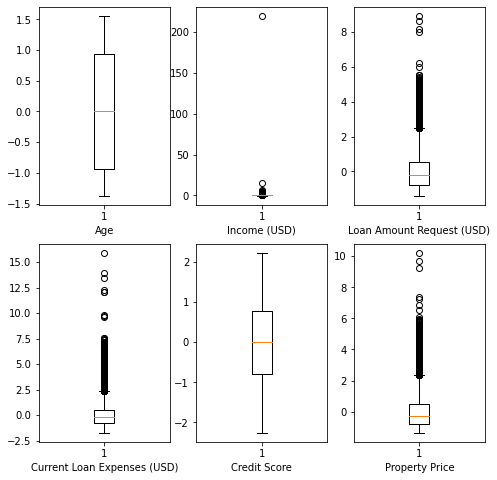

In [59]:
row = 2
col = 3
columns = ['Age','Income (USD)','Loan Amount Request (USD)','Current Loan Expenses (USD)','Credit Score','Property Price']
plt.figure(figsize = (8,8))
for i,j in enumerate(columns,start =1):
    plt.subplot(row,col,i); plt.boxplot([df_total[j]])
    plt.xlabel(j)

##### Let compare the distribution plot of numerical features with normal distribution
##### The black line is the normal distribution curve
##### The blue line the is actual distribution curve

<Figure size 576x720 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:xlabel='Age'>

Text(0.5, 0, 'Age')

<AxesSubplot:>

<AxesSubplot:xlabel='Income (USD)'>

Text(0.5, 0, 'Income (USD)')

<AxesSubplot:>

<AxesSubplot:xlabel='Loan Amount Request (USD)'>

Text(0.5, 0, 'Loan Amount Request (USD)')

<AxesSubplot:>

<AxesSubplot:xlabel='Current Loan Expenses (USD)'>

Text(0.5, 0, 'Current Loan Expenses (USD)')

<AxesSubplot:>

<AxesSubplot:xlabel='Credit Score'>

Text(0.5, 0, 'Credit Score')

<AxesSubplot:>

<AxesSubplot:xlabel='Property Price'>

Text(0.5, 0, 'Property Price')

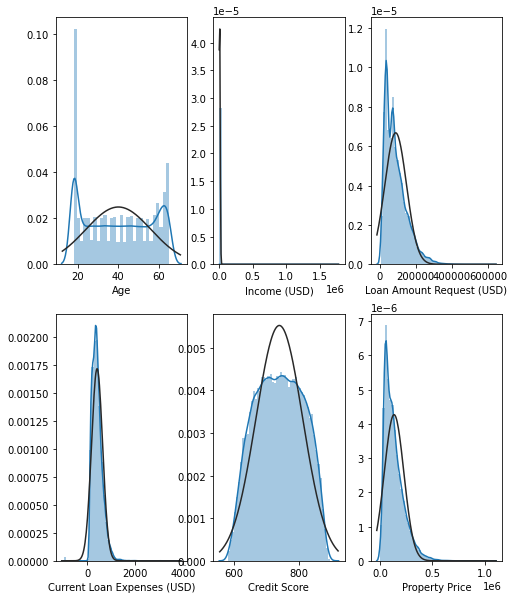

In [17]:
plt.figure(figsize = (8,10))
for i,j in enumerate(columns,start =1):
    plt.subplot(row,col,i); sns.distplot(df_total[j],fit = norm, kde = True, label = j)
    plt.xlabel(j)

##### Checking the missing values in every column.
##### We have most number of missing data in column: 'Type of Employment'

In [18]:
df_total.isnull().sum(axis = 0).sort_values(ascending = False).to_frame('missing_value').reset_index()

,index,missing_value
0,Loan Sanction Amount (USD),20340
1,Type of Employment,11959
2,Property Age,5742
3,Income (USD),5326
4,Dependents,3635
5,Has Active Credit Card,2642
6,Income Stability,2496
7,Credit Score,2446
8,Property Location,516
9,Current Loan Expenses (USD),255


In [19]:
# We have balanced Gender

df_total['Gender'].value_counts(normalize=True)

F    0.501563
M    0.498437
Name: Gender, dtype: float64

In [20]:
# imputing the missing values using forward fill. and also maintaining the ration of the two classes

df_total['Gender'] = df_total['Gender'].fillna(method='ffill')
df_total['Gender'].value_counts(normalize=True)

F    0.50152
M    0.49848
Name: Gender, dtype: float64

##### The target is more correlated to 'Loan Amount Requested (USD)', 'Current Loan Expenses (USD)', 'Credit Score'
##### 'Loan Amount Requested (USD)' is strongly correlated to 'Current Loan Expenses (USD)'

<AxesSubplot:>

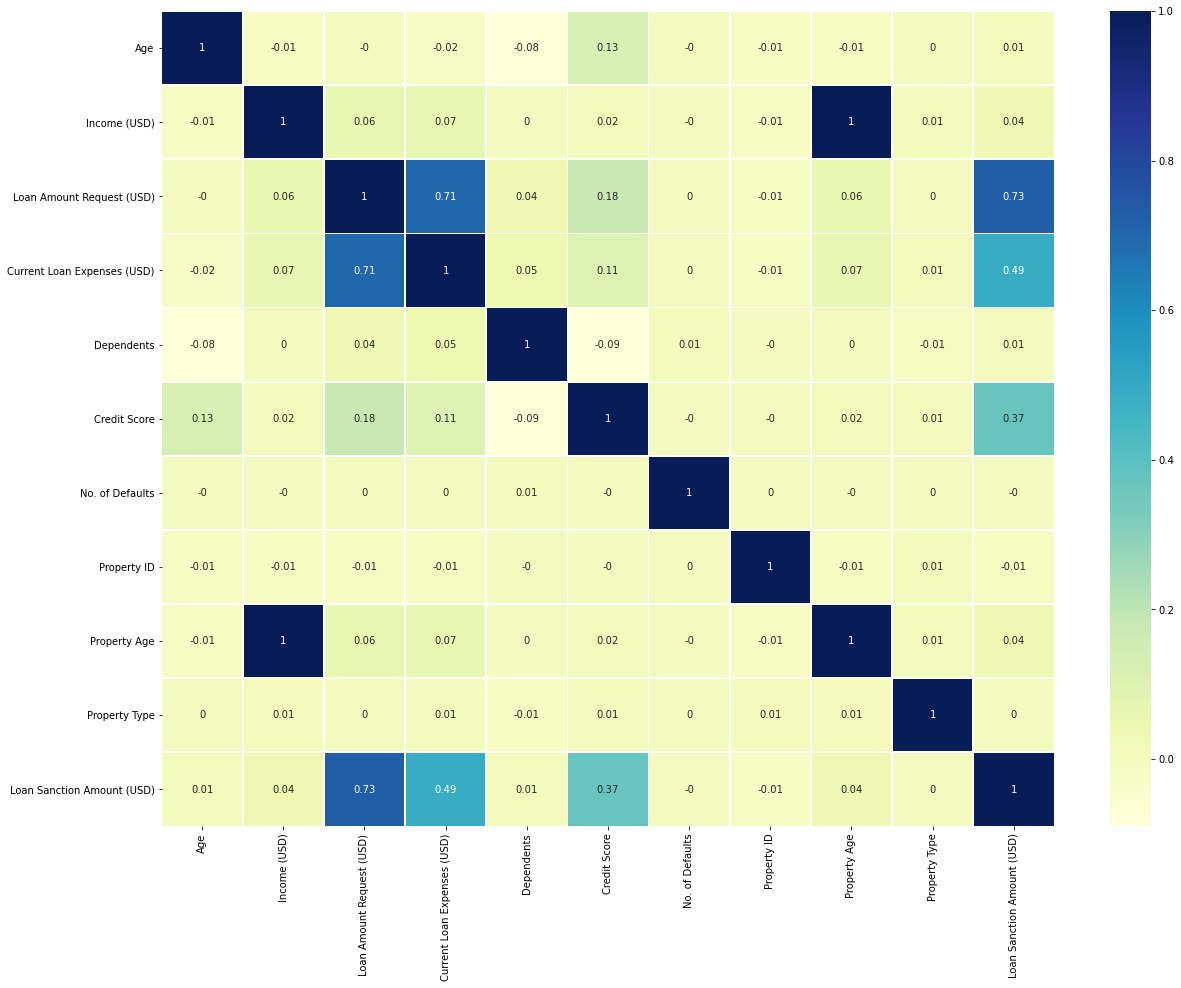

In [21]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(data=df_total.corr().round(2), annot=True, linewidths=0.7, cmap='YlGnBu')
plt.show()

##### median income of every profession

In [22]:
pivot_table = df_total.pivot_table(
    index=['Profession'],
    values=['Income (USD)'],
    aggfunc={'Income (USD)': 'median'}
)

df2 = pivot_table.rename_axis(None, axis=1).reset_index()
df2

,Profession,Income (USD)
0,Businessman,6425.990
1,Commercial associate,2569.610
2,Maternity leave,734.490
3,Pensioner,1909.665
4,State servant,2308.285
5,Student,2446.100
6,Unemployed,805.370
7,Working,2115.410


In [23]:
# Imputing misssing values in the column: 'Income (USD)' with the median income of evry profession

df_total['Income (USD)'] = df_total['Income (USD)'].fillna(df_total.groupby('Profession')['Income (USD)'].transform('median'))

In [24]:
# We have almost 90% of customer who have LOW income stability

df_total['Income Stability'].value_counts(normalize=True)

Low     0.910492
High    0.089508
Name: Income Stability, dtype: float64

In [25]:
# All the people whose income stabilty is High  are Pensioners since they get there pensions timely hence income is stable
# and hence they dont have any Type of employement as they are retired

df_total[df_total['Income Stability'] == 'High'][['Income Stability','Profession','Type of Employment']].shape
df_total[df_total['Income Stability'] == 'High'][['Income Stability','Profession','Type of Employment']].head()
df_total[df_total['Income Stability'] == 'High'][['Income Stability','Profession','Type of Employment']].tail()

(4252, 3)

,Income Stability,Profession,Type of Employment
2,High,Pensioner,NaN
3,High,Pensioner,NaN
18,High,Pensioner,NaN
25,High,Pensioner,NaN
64,High,Pensioner,NaN


,Income Stability,Profession,Type of Employment
49913,High,Pensioner,NaN
49967,High,Pensioner,NaN
49974,High,Pensioner,NaN
49977,High,Pensioner,NaN
49990,High,Pensioner,NaN


In [26]:
# we have 3 unique locaitons out of which most people live in Semi Urban areas
df_total['Location'].value_counts()

Semi-Urban    36026
Rural          8774
Urban          5200
Name: Location, dtype: int64

In [27]:
# we see that for every profession, the income for Urban Area is higher than semi-urban and rural.
# and this justified as the cost of living is higher in Urabn is higher

pivot_table = df_total.pivot_table(
    index=['Location'],
    columns=['Profession'],
    values=['Income (USD)'],
    aggfunc={'Income (USD)': 'mean'}
)


pivot_table.columns = [
    '_'.join([str(c) for c in col]).strip() if isinstance(col, tuple) else col
    for col in pivot_table.columns.values
]


df2 = pivot_table.rename_axis(None, axis=1).reset_index()
df2

,Location,Income (USD)_Businessman,Income (USD)_Commercial associate,Income (USD)_Maternity leave,Income (USD)_Pensioner,Income (USD)_State servant,Income (USD)_Student,Income (USD)_Unemployed,Income (USD)_Working
0,Rural,NaN,2559.899130,NaN,2037.489156,2367.530780,2446.100000,1405.005,2258.942773
1,Semi-Urban,2551.67,2749.451674,734.49,2062.891211,2460.834855,2247.513333,614.665,2418.958214
2,Urban,10300.31,3825.195853,734.49,2991.677913,3395.291821,3315.770000,NaN,3229.757321


In [28]:
# imputing the column: 'Income Stability' with most frequent value i.e LOW

df_total['Income Stability'] = df_total['Income Stability'].fillna(df_total['Income Stability'].mode()[0])

In [29]:
# We have many different types of values in column:'Type of Employment'
# Also we saw previously that there are many missing values in this column.

df_total['Type of Employment'].value_counts()

Laborers                 9321
Sales staff              6169
Core staff               5462
Managers                 4214
Drivers                  2663
Accountants              2265
High skill tech staff    2188
Medicine staff           1462
Cooking staff             971
Security staff            956
Cleaning staff            571
Private service staff     543
Low-skill Laborers        303
Secretaries               280
Waiters/barmen staff      259
Realty agents             154
HR staff                  132
IT staff                  128
Name: Type of Employment, dtype: int64

##### median of Income based of type of Employement

In [30]:
pivot_table = df_total.pivot_table(
    index=['Type of Employment'],
    values=['Income (USD)'],
    aggfunc={'Income (USD)': 'median'}
)


df2 = pivot_table.rename_axis(None, axis=1).reset_index()

df2 = df2.sort_values(by='Income (USD)', ascending=False, na_position='first')
df2 = df2.reset_index(drop=True)
df2

,Type of Employment,Income (USD)
0,Managers,3103.495
1,IT staff,2483.910
2,Drivers,2446.810
3,Realty agents,2446.685
4,Accountants,2421.150
5,Private service staff,2382.290
6,High skill tech staff,2311.680
7,HR staff,2195.775
8,Core staff,2174.180
9,Laborers,2115.410


In [31]:
df_total['Type of Employment'].value_counts(normalize = True).sort_values(ascending = False).to_frame('Before_value').reset_index()

,index,Before_value
0,Laborers,0.245025
1,Sales staff,0.162167
2,Core staff,0.143582
3,Managers,0.110775
4,Drivers,0.070003
5,Accountants,0.059541
6,High skill tech staff,0.057517
7,Medicine staff,0.038432
8,Cooking staff,0.025525
9,Security staff,0.025131


In [32]:
# forward filling(imptation) and keeping the ratio constant as before
# also showing the comparison in ratio - BEFORE and AFTER the imputaiton


before = df_total['Type of Employment'].value_counts(normalize = True).sort_values(ascending = False).to_frame('Before_imputing').reset_index()

df_total['Type of Employment'] = df_total['Type of Employment'].fillna(method='ffill')

after = df_total['Type of Employment'].value_counts(normalize = True).sort_values(ascending = False).to_frame('After_imputing').reset_index()

combine = [before, after[after.columns[-1]]] # for variable 'after', we are only fetching the column with values and not 
                                             # the index
pd.concat(combine,axis = 1)

,index,Before_imputing,After_imputing
0,Laborers,0.245025,0.24406
1,Sales staff,0.162167,0.16390
2,Core staff,0.143582,0.14232
3,Managers,0.110775,0.11032
4,Drivers,0.070003,0.06936
5,Accountants,0.059541,0.05944
6,High skill tech staff,0.057517,0.05858
7,Medicine staff,0.038432,0.03820
8,Cooking staff,0.025525,0.02588
9,Security staff,0.025131,0.02550


##### Changing the 'type of employemnt' to a broad category: 'Low_Skilled', 'Medium_Skilled', 'High_skilled', 'Advance_skilled'

In [33]:
df_total['Type of Employment'] = df_total['Type of Employment'].map(
    
                                    {'Cleaning staff' : 'Low_Skilled',
                                     'Low-skill Laborers' : 'Low_Skilled',
                                     'Cooking staff' : 'Low_Skilled',
                                     
                                     'HR staff' : 'Medium_Skilled',
                                     'Laborers' : 'Medium_Skilled',
                                     'Medicine staff' : 'Medium_Skilled',
                                     'Waiters/barmen staff' : 'Medium_Skilled',
                                     'Sales staff' : 'Medium_Skilled',
                                     'Secretaries' : 'Medium_Skilled',
                                     'Security staff' : 'Medium_Skilled',
                                     'Core staff' : 'Medium_Skilled',
                                     
                                     'High skill tech staff' : 'High_skilled',
                                     'Private service staff' : 'High_skilled',
                                     'Accountants' :'High_skilled',
                                     'IT staff' : 'High_skilled',
                                     'Drivers' : 'High_skilled',
                                     'Realty agents' : 'High_skilled',
                                     
                                     'Managers' : 'Advance_skilled'
                                    })

##### We have more of 'Medium_Skilled' customers.

In [34]:
df_total['Type of Employment'].value_counts(normalize = True)

Medium_Skilled     0.63198
High_skilled       0.20874
Advance_skilled    0.11032
Low_Skilled        0.04896
Name: Type of Employment, dtype: float64

<AxesSubplot:xlabel='Current Loan Expenses (USD)'>

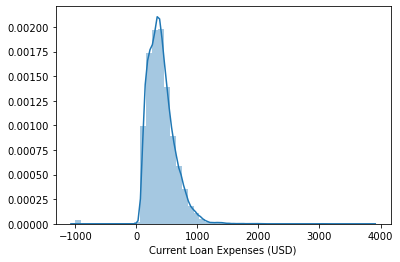

In [35]:
# seems like we have -ve values in column:'Current Loan Expenses (USD)'
sns.distplot(df_total['Current Loan Expenses (USD)'])

In [37]:
# Checking the specific value the column is holding. All the values are -999 which is equivalent to NaN

df_total[df_total['Current Loan Expenses (USD)'] < 0].shape
df_total[df_total['Current Loan Expenses (USD)'] < 0]['Current Loan Expenses (USD)'].to_frame().head()

(177, 23)

,Current Loan Expenses (USD)
303,-999.0
518,-999.0
567,-999.0
724,-999.0
832,-999.0


In [38]:
# converting all the -ve values as Nan

df_total['Current Loan Expenses (USD)'] = df_total.apply(
    
lambda x: None if x['Current Loan Expenses (USD)'] == -999.0
               else x['Current Loan Expenses (USD)'],axis = 1
)

In [39]:
# imputing all the NaN in column: 'Current Loan Expenses (USD)' with median of this column

df_total['Current Loan Expenses (USD)'] = df_total['Current Loan Expenses (USD)'].fillna(
    (df_total['Current Loan Expenses (USD)'].median())
)

<AxesSubplot:xlabel='Dependents', ylabel='count'>

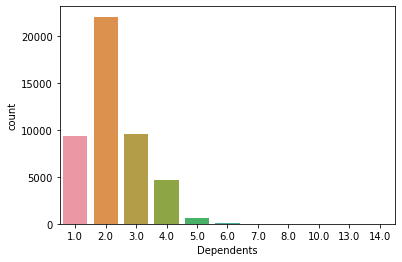

In [40]:
# checking the number of 'Dependents' the customer has. Most of the applicants have 2 members in dependents

sns.countplot(df_total['Dependents'])

In [41]:
# imputing the Nans in column:'Dependents'

df_total['Dependents'] = df_total['Dependents'].fillna(0.0)

<AxesSubplot:xlabel='Credit Score'>

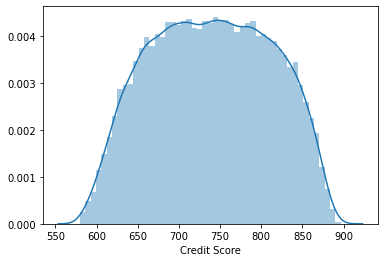

In [42]:
# analyzing the distribution plot for column:'Credit Score'. The plot shows close to normal distribution

sns.distplot(df_total['Credit Score'])

In [43]:
# imputing the Nans with a mean credit score

df_total['Credit Score'] = df_total['Credit Score'].fillna((df_total['Credit Score'].mean()))

In [44]:
# Some of the values in column: 'Has Active Credit Card'are NaNs, hence we will fill those Nans with category 'Unpossessed'

df_total['Has Active Credit Card'] = df_total['Has Active Credit Card'].fillna('Unpossessed')

In [45]:
# 'Property ID' has high cardinality. Therefore dropping the column
df_total.drop(columns = 'Property ID', axis = 1, inplace = True)
df_total.shape

(50000, 22)

In [46]:
# here we can see that the data value for 'Property Age' is same as 'Income (USD)'. hence we are dropping 'Property Age'
# since this will behave as a Redundant feature in our dataset
df_total[['Income (USD)','Property Age']].head(20)
df_total.drop(columns = 'Property Age', axis = 1, inplace = True)
df_total.shape

,Income (USD),Property Age
0,1933.050,1933.05
1,4952.910,4952.91
2,988.190,988.19
3,1909.665,NaN
4,2614.770,2614.77
5,1234.920,1234.92
6,2361.560,2361.56
7,2308.285,NaN
8,1296.070,1296.07
9,1546.170,1546.17


(50000, 21)

In [47]:
# forward filling(imptation) and keeping the ratio constant as before
# also showing the comparison in ratio - BEFORE and AFTER the imputaiton

before = df_total['Property Location'].value_counts(normalize=True).sort_values(ascending = False).to_frame('Before_imputing').reset_index()

df_total['Property Location'] = df_total['Property Location'].fillna(method='ffill')

after = df_total['Property Location'].value_counts(normalize=True).sort_values(ascending = False).to_frame('After_imputing').reset_index()

combine = [before, after[after.columns[-1]]] # for variable 'after', we are only fetching the column with values and not 
                                             # the index associated with the column as it will be same
pd.concat(combine,axis = 1)

,index,Before_imputing,After_imputing
0,Semi-Urban,0.348113,0.34830
1,Rural,0.339686,0.33962
2,Urban,0.312202,0.31208


##### We are now checking if the customers wants to buy Property at same location where they are residing currently or in other places.

In [48]:
# making all the possible combinations betweent he unique values of column:'Location' and 'Property Location'

unique_location_list = df_total['Location'].unique().tolist()
unique_property_location_list = df_total['Property Location'].unique().tolist()

combinaitons = list(itertools.product(unique_location_list, unique_property_location_list))

def location_count(df, location,property_location, combo):
    for i in range(len(combo)):
        print(f'Number of customer whose CURRENT location: {combo[i][0]} and PROPERTY location: {combo[i][1]} = ',end =' ')
        print(df[(df[location] == combo[i][0]) & (df[property_location] == combo[i][1])].shape[0])

#####  From the below result we can see that most people of semi-urban area are purchasing property in all types of property location also we can see that it is diffcult for any location customer(rural, semi, urban) to buy property in Urban area.

In [49]:
location_count(df_total, 'Location', 'Property Location', combinaitons)

Number of customer whose CURRENT location: Semi-Urban and PROPERTY location: Rural =  12274
Number of customer whose CURRENT location: Semi-Urban and PROPERTY location: Urban =  11257
Number of customer whose CURRENT location: Semi-Urban and PROPERTY location: Semi-Urban =  12495
Number of customer whose CURRENT location: Rural and PROPERTY location: Rural =  2946
Number of customer whose CURRENT location: Rural and PROPERTY location: Urban =  2675
Number of customer whose CURRENT location: Rural and PROPERTY location: Semi-Urban =  3153
Number of customer whose CURRENT location: Urban and PROPERTY location: Rural =  1761
Number of customer whose CURRENT location: Urban and PROPERTY location: Urban =  1672
Number of customer whose CURRENT location: Urban and PROPERTY location: Semi-Urban =  1767


In [50]:
# The column:'Co-Applicant' has some dummy values(-999), we need to impute it with mode
df_total['Co-Applicant'].value_counts()

mode_Co_Applicant = df_total['Co-Applicant'].mode()[0]
df_total['Co-Applicant'] = df_total.apply(lambda x: mode_Co_Applicant if x['Co-Applicant'] == -999 
                                          or pd.isnull(x['Co-Applicant']) 
                                            else x['Co-Applicant'],axis = 1)

1       25516
1       17004
0        4316
0        2919
-999      168
Name: Co-Applicant, dtype: int64

In [51]:
# We have dummy values(-999) again in column:'Property Price'. Replacing these dummy values with median of this column

median_Property_Price = df_total['Property Price'].median()
df_total['Property Price'] = df_total.apply(lambda x: median_Property_Price if x['Property Price'] == -999 
                                            or pd.isnull(x['Property Price'])
                                            else x['Property Price'],axis = 1)

#####  In target variable:'Loan Sanction Amount (USD)' , we have Nan and also dummy values like -999, we need to impute the values

In [52]:
df_total[df_total['Loan Sanction Amount (USD)'] < 0].shape
df_total[df_total['Loan Sanction Amount (USD)'] < 0]['Loan Sanction Amount (USD)'].to_frame('Dummy values in Target').head()
df_total[df_total['Loan Sanction Amount (USD)'] < 0]['Loan Sanction Amount (USD)'].to_frame('Dummy values in Target').tail()

(338, 21)

,Dummy values in Target
22,-999.0
145,-999.0
250,-999.0
387,-999.0
484,-999.0


,Dummy values in Target
29872,-999.0
29912,-999.0
29932,-999.0
29934,-999.0
29942,-999.0


##### We are checking the ratio of 'Loan Sanction Amount (USD)' to 'Loan Amount Request (USD)' and found that the most common value is 0.7. Hence we multiply the loan requested amount by 0.7 to get the loan sanctioned amount to replace the dummies and Nan from 'Train' dataset only

In [53]:
ratio_of_sanction_by_requested = df_total.apply(lambda x: round((x['Loan Sanction Amount (USD)']/x['Loan Amount Request (USD)']),2),axis = 1)
most_frequent_ratio = ratio_of_sanction_by_requested.value_counts().index[0]
print(f'Most Frequent ratio --> {most_frequent_ratio}')

df_total['Loan Sanction Amount (USD)'] = df_total.apply(lambda x:  
                most_frequent_ratio* x['Loan Amount Request (USD)'] 
                if ((x['Loan Sanction Amount (USD)'] < 0 or pd.isnull(x['Loan Sanction Amount (USD)'])) and x['Status'] == 'Train')
                else x['Loan Sanction Amount (USD)'],axis = 1)

Most Frequent ratio --> 0.7


In [54]:
# Co-Applicant and Property Price  have different data type in test dataset
# hence changing the data type of these columns to same as train dataset

df_total['Co-Applicant'] = df_total['Co-Applicant'].astype('int')
df_total['Property Price'] = df_total['Property Price'].astype('float')

##### Dividing the features into categorical and numerical

In [55]:
numerical_columns = [x for x in df_total.dtypes.index if df_total.dtypes[x] !='object']
numerical_categorical = ['Dependents','No. of Defaults','Property Type','Co-Applicant']
numerical_columns =  [item for item in numerical_columns if item not in numerical_categorical]
numerical_columns

['Age',
 'Income (USD)',
 'Loan Amount Request (USD)',
 'Current Loan Expenses (USD)',
 'Credit Score',
 'Property Price',
 'Loan Sanction Amount (USD)']

In [56]:
# 'Dependets','No. of Defaults','Property Type','Co-Applicant' are also categorical but they are already encoded in integer
# so including it in categorical list

catergorical_columns = [x for x in df_total.dtypes.index if df_total.dtypes[x]=='object']
catergorical_columns += ['Dependents','No. of Defaults','Property Type','Co-Applicant']
catergorical_columns

['Gender',
 'Income Stability',
 'Profession',
 'Type of Employment',
 'Location',
 'Expense Type 1',
 'Expense Type 2',
 'Has Active Credit Card',
 'Property Location',
 'Status',
 'Dependents',
 'No. of Defaults',
 'Property Type',
 'Co-Applicant']

In [57]:
# One hot encoding for categorical variables.

for i in catergorical_columns:
    if df_total[i].dtypes == 'int' or df_total[i].dtypes == 'float':
        df_total[i] = df_total[i].astype('str')
        df_total = pd.get_dummies(df_total, prefix = [i],columns=[i],drop_first = True)
    else:
        df_total = pd.get_dummies(df_total, prefix = [i],columns=[i],drop_first = True)

In [58]:
# Standardizing the numerical features

from sklearn.preprocessing import StandardScaler

numerical_columns_without_target = numerical_columns
numerical_columns_without_target.remove('Loan Sanction Amount (USD)')

df_total[numerical_columns_without_target] = StandardScaler().fit_transform(df_total[numerical_columns_without_target])
df_total.head()

,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Credit Score,Property Price,Loan Sanction Amount (USD),Gender_M,Income Stability_Low,Profession_Commercial associate,Profession_Maternity leave,Profession_Pensioner,Profession_State servant,Profession_Student,Profession_Unemployed,Profession_Working,Type of Employment_High_skilled,Type of Employment_Low_Skilled,Type of Employment_Medium_Skilled,Location_Semi-Urban,Location_Urban,Expense Type 1_Y,Expense Type 2_Y,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Semi-Urban,Property Location_Urban,Status_Train,Dependents_1.0,Dependents_10.0,Dependents_13.0,Dependents_14.0,Dependents_2.0,Dependents_3.0,Dependents_4.0,Dependents_5.0,Dependents_6.0,Dependents_7.0,Dependents_8.0,No. of Defaults_1,Property Type_2,Property Type_3,Property Type_4,Co-Applicant_1
0,0.993927,-0.076616,-0.268397,-0.775672,0.993083,-0.142624,54607.18,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1
1,-0.499912,0.297122,-0.703264,0.403311,0.581010,-0.845656,37469.98,1,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,1.554116,-0.193552,-0.724100,-1.095630,1.329525,-0.655178,36474.43,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1.554116,-0.079510,-0.147034,-0.509726,1.323139,-0.126349,56040.54,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1
4,-0.562155,0.007754,0.418916,0.382946,0.086493,0.813938,74008.28,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1


#### Checking the kurtosis and skewness
##### Skewness: measures the symmetry of data
##### Kurtosis: measures if the data is heavy-tailed or light-tailed

In [60]:
def kurtosis_and_skew(columns):
    for i in columns:
        print(f'kurtosis_{i}:  {kurtosis(df_total[i], bias=False)} skew_{i}: {skew(df_total[i], bias=False)}')

In [61]:
columns = ['Age','Income (USD)','Loan Amount Request (USD)','Current Loan Expenses (USD)','Credit Score','Property Price']
kurtosis_and_skew(columns)

kurtosis_Age:  -1.3840379904021076 skew_Age: 0.049711961292698205
kurtosis_Income (USD):  46567.4143422599 skew_Income (USD): 212.08360995787487
kurtosis_Loan Amount Request (USD):  2.0493647954209866 skew_Loan Amount Request (USD): 1.2674209041982714
kurtosis_Current Loan Expenses (USD):  6.99835635712747 skew_Current Loan Expenses (USD): 1.4815635379732905
kurtosis_Credit Score:  -0.8842160134118155 skew_Credit Score: -0.017474520875464042
kurtosis_Property Price:  3.001830571194752 skew_Property Price: 1.4355436786135727


In [62]:
df_total.to_csv('cleaned_data.csv',index = False)

##### Separating the df_total back into train and test

In [63]:
train = df_total[df_total['Status_Train'] == 1]
train = train.drop(['Status_Train'],axis = 1)
print('Train_data shape: ',train.shape)

test = df_total[df_total['Status_Train'] == 0]
test = test.drop(['Status_Train','Loan Sanction Amount (USD)'],axis = 1)
print('Test_data shape: ',test.shape)

Train_data shape:  (30000, 43)
Test_data shape:  (20000, 42)


##### The good old train-test split !!!

In [64]:
X = train.drop(['Loan Sanction Amount (USD)'],axis = 1)
y = train['Loan Sanction Amount (USD)']
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size = 0.2,random_state = 42)
X_train.shape,X_valid.shape

((24000, 42), (6000, 42))

#### We will be using Light Gradient Boosted(regression)
#### Also we will be doing the hyperparamater tuning for some of its parameters

In [65]:
# giving different values to the parameters on which it will get trained and returning the best values

n_HP_points_to_test = 10

params={"early_stopping_rounds":30, 
            "eval_metric" : 'mse', 
            "eval_set" : [(X_valid,y_valid)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'
        }

param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             }

In [66]:
# using KFold for cross validaiton - 10 Fold
cv = KFold(n_splits = 10, shuffle = True, random_state = 100)

# creating the object for LGBM
clf = lgb(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=-1, n_estimators=5000)

# using RandomizedSearchCV to loop through predefined hyperparameters and fit the estimator on the training set
# and validating on Validation set

gs = RandomizedSearchCV(
    estimator=clf, 
    param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='r2',
    cv=cv,
    refit=True,
    random_state=314,
    verbose=True)

# Lets train !!!!
gs.fit(X_train, y_train, **params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Training until validation scores don't improve for 30 rounds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[100]	valid's l2: 5.02685e+08
[200]	valid's l2: 4.99921e+08
[300]	valid's l2: 4.98712e+08
Early stopping, best iteration is:
[306]	valid's l2: 4.98513e+08
Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 4.99467e+08
[200]	valid's l2: 4.94828e+08
Early stopping, best iteration is:
[210]	valid's l2: 4.9467e+08
Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 4.94716e+08
[200]	valid's l2: 4.91099e+08
Early stopping, best iteration is:
[220]	valid's l2: 4.89839e+08
Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 4.99152e+08
Early stopping, best iteration is:
[133]	valid's l2: 4.97006e+08
Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 4.95789e+08
[200]	valid's l2: 4.89821e+08
Early stopping, best iteration is:
[195]	valid's l2: 4.89606e+08
Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 4.94369e+08
[200]	valid's l2: 4.88198e+08
Early stopp

[2200]	valid's l2: 1.39275e+09
[2300]	valid's l2: 1.39272e+09
[2400]	valid's l2: 1.39269e+09
[2500]	valid's l2: 1.39266e+09
[2600]	valid's l2: 1.39262e+09
[2700]	valid's l2: 1.39259e+09
[2800]	valid's l2: 1.39257e+09
[2900]	valid's l2: 1.39254e+09
[3000]	valid's l2: 1.39252e+09
[3100]	valid's l2: 1.3925e+09
[3200]	valid's l2: 1.39247e+09
[3300]	valid's l2: 1.39246e+09
[3400]	valid's l2: 1.39244e+09
[3500]	valid's l2: 1.39241e+09
[3600]	valid's l2: 1.39239e+09
[3700]	valid's l2: 1.39238e+09
[3800]	valid's l2: 1.39236e+09
[3900]	valid's l2: 1.39235e+09
[4000]	valid's l2: 1.39233e+09
Early stopping, best iteration is:
[4017]	valid's l2: 1.39233e+09
Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 1.39604e+09
Early stopping, best iteration is:
[99]	valid's l2: 1.39604e+09
Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 1.39619e+09
[200]	valid's l2: 1.39582e+09
[300]	valid's l2: 1.39555e+09
[400]	valid's l2: 1.39531e+09
[500]	vali

Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 5.13256e+08
[200]	valid's l2: 4.98471e+08
Early stopping, best iteration is:
[225]	valid's l2: 4.96247e+08
Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 5.09944e+08
[200]	valid's l2: 4.9932e+08
Early stopping, best iteration is:
[251]	valid's l2: 4.97342e+08
Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 5.12622e+08
[200]	valid's l2: 5.00954e+08
[300]	valid's l2: 4.96836e+08
Early stopping, best iteration is:
[281]	valid's l2: 4.95837e+08
Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 5.14698e+08
[200]	valid's l2: 5.02176e+08
[300]	valid's l2: 4.98886e+08
Early stopping, best iteration is:
[350]	valid's l2: 4.9652e+08
Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 5.08304e+08
[200]	valid's l2: 5.00029e+08
Early stopping, best iteration is:
[269]	valid's l2: 4.95286e+08
Training unt

Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 4.72617e+08
Early stopping, best iteration is:
[113]	valid's l2: 4.72116e+08
Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 4.70521e+08
Early stopping, best iteration is:
[159]	valid's l2: 4.68551e+08
Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 4.6734e+08
Early stopping, best iteration is:
[128]	valid's l2: 4.65488e+08
Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 4.70692e+08
Early stopping, best iteration is:
[103]	valid's l2: 4.69827e+08
Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 4.66132e+08
Early stopping, best iteration is:
[118]	valid's l2: 4.65117e+08
Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 4.63794e+08
Early stopping, best iteration is:
[130]	valid's l2: 4.62487e+08
Training until validation scores don't improve for 30 rounds
[100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.1min finished


Training until validation scores don't improve for 30 rounds
[100]	valid's l2: 4.67128e+08
Early stopping, best iteration is:
[137]	valid's l2: 4.66067e+08


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=100, shuffle=True),
                   estimator=LGBMRegressor(metric='None', n_estimators=5000,
                                           random_state=314),
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000017FE7643048>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000017FE7624A88>,
                                        '...d_weight': [1e-05, 0.001, 0.01,
                                                             0.1, 1, 10.0,
                                                             100.0, 1000.0,
                                                             10000.0],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000017FE7624988>,
                                        'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10,
        

##### Lets frame all the score in decreasing order of scores

In [67]:
cv_results = pd.DataFrame(gs.cv_results_).sort_values(by = 'rank_test_score')
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_min_child_samples,param_min_child_weight,param_num_leaves,param_reg_alpha,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
9,0.564454,0.066276,0.018650,0.003124,0.556075,103,10,22,2,1,0.893911,"{'colsample_bytree': 0.55607546409401, 'min_child_samples': 103, 'min_child_weight': 10.0, 'num_leaves': 22, 'reg_alpha': 2, 'reg_lambda': 1, 'subsample': 0.8939112927620336}",0.743350,0.816275,0.806822,0.810009,0.815701,0.783904,0.782236,0.798413,0.755927,0.804012,0.791665,0.023892,1
5,0.509870,0.090504,0.019947,0.004136,0.687909,163,10,10,1,0.1,0.677506,"{'colsample_bytree': 0.6879091728281055, 'min_child_samples': 163, 'min_child_weight': 10.0, 'num_leaves': 10, 'reg_alpha': 1, 'reg_lambda': 0.1, 'subsample': 0.6775057521029393}",0.741640,0.813780,0.805910,0.807233,0.810583,0.779057,0.780695,0.797566,0.753922,0.799406,0.788979,0.023497,2
8,0.556203,0.103711,0.021768,0.004721,0.727199,212,0.01,13,0.1,5,0.447821,"{'colsample_bytree': 0.7271985991098294, 'min_child_samples': 212, 'min_child_weight': 0.01, 'num_leaves': 13, 'reg_alpha': 0.1, 'reg_lambda': 5, 'subsample': 0.44782056066342807}",0.743199,0.814840,0.805236,0.802374,0.809093,0.780888,0.781415,0.796185,0.756490,0.799383,0.788910,0.022251,3
1,0.998874,0.116854,0.026827,0.004492,0.973167,171,1e-05,41,10,100,0.557573,"{'colsample_bytree': 0.9731668400523877, 'min_child_samples': 171, 'min_child_weight': 1e-05, 'num_leaves': 41, 'reg_alpha': 10, 'reg_lambda': 100, 'subsample': 0.5575732396028996}",0.737554,0.812157,0.795958,0.798836,0.806764,0.775291,0.782449,0.787004,0.755845,0.794293,0.784615,0.021940,4
0,0.933929,0.114328,0.032123,0.006029,0.950124,301,0.1,28,0,100,0.932647,"{'colsample_bytree': 0.9501241488957805, 'min_child_samples': 301, 'min_child_weight': 0.1, 'num_leaves': 28, 'reg_alpha': 0, 'reg_lambda': 100, 'subsample': 0.9326466073236168}",0.736174,0.808361,0.800447,0.797231,0.799818,0.774377,0.778616,0.791159,0.750823,0.794897,0.783190,0.022276,5
6,1.287062,0.165994,0.035310,0.007123,0.875437,372,10,44,1,0,0.568664,"{'colsample_bytree': 0.8754369812451743, 'min_child_samples': 372, 'min_child_weight': 10.0, 'num_leaves': 44, 'reg_alpha': 1, 'reg_lambda': 0, 'subsample': 0.568664015245299}",0.740086,0.807535,0.797766,0.796300,0.796321,0.773024,0.777918,0.791193,0.752329,0.797069,0.782954,0.020850,6
4,1.055085,0.206515,0.042190,0.009357,0.806323,491,0.1,24,100,20,0.656442,"{'colsample_bytree': 0.8063232376017694, 'min_child_samples': 491, 'min_child_weight': 0.1, 'num_leaves': 24, 'reg_alpha': 100, 'reg_lambda': 20, 'subsample': 0.6564417745729645}",0.743788,0.806217,0.797298,0.791184,0.794250,0.764321,0.776718,0.786330,0.748327,0.797007,0.780544,0.020524,7
7,1.394324,0.169116,0.043889,0.006074,0.404829,350,0.001,36,1,5,0.927402,"{'colsample_bytree': 0.404828563763895, 'min_child_samples': 350, 'min_child_weight': 0.001, 'num_leaves': 36, 'reg_alpha': 1, 'reg_lambda': 5, 'subsample': 0.9274016358891894}",0.739050,0.803806,0.795103,0.796679,0.793582,0.768489,0.773965,0.789094,0.749471,0.795154,0.780439,0.020846,8
3,2.199049,0.425418,0.079404,0.009631,0.819604,422,1000,28,2,5,0.664986,"{'colsample_bytree': 0.8196039247657971, 'min_child_samples': 422, 'min_child_weight': 1000.0, 'num_leaves': 28, 'reg_alpha': 2, 'reg_lambda': 5, 'subsample': 0.6649855489918759}",0.735913,0.803062,0.790043,0.792719,0.788583,0.764076,0.770644,0.784089,0.736166,0.786523,0.775182,0.022139,9
2,2.664428,1.447176,0.071611,0.031907,0.775604,424,10000,30,0,100,0.934866,"{'colsample_bytree': 0.7756038066515227, 'min_child_samples': 424, 'min_child_weight': 10000.0, 'num_leaves': 30, 'reg_alpha': 0, 'reg_lambda': 100, 'subsample': 0.9348658101450167}",0.373585,0.415889,0.394900,0.380943,0.403325,0

##### Let check what is the best score and the best parameters based on training set

In [68]:
print('Best score reached: {} \n\nParams: {} '.format(gs.best_score_, gs.best_params_))

Best score reached: 0.7916648997080327 

Params: {'colsample_bytree': 0.55607546409401, 'min_child_samples': 103, 'min_child_weight': 10.0, 'num_leaves': 22, 'reg_alpha': 2, 'reg_lambda': 1, 'subsample': 0.8939112927620336} 


##### Ranking the features based on their importance in the dataset

In [69]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

#### Variance Inflation Factor
##### VIF directly depend on R2 score

In [71]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = train.columns
vif_data["VIF"] = [variance_inflation_factor(train.values, i)for i in range(len(train.columns))]

vif_data.sort_values(by = 'VIF',ascending = False)

,feature,VIF
8,Income Stability_Low,164.814594
15,Profession_Working,127.867503
9,Profession_Commercial associate,60.592908
12,Profession_State servant,18.660237
2,Loan Amount Request (USD),15.262460
5,Property Price,12.417281
42,Co-Applicant_1,8.872347
18,Type of Employment_Medium_Skilled,7.025917
31,Dependents_2.0,6.325535
6,Loan Sanction Amount (USD),6.027072


##### Now we will train our data on optimized hyperparameters parameters

In [72]:
opt_parameters = gs.best_params_

clf_final = lgb(**opt_parameters)
clf_final.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.55607546409401, min_child_samples=103,
              min_child_weight=10.0, num_leaves=22, reg_alpha=2, reg_lambda=1,
              subsample=0.8939112927620336)

##### Plotting the feature importance bar graph

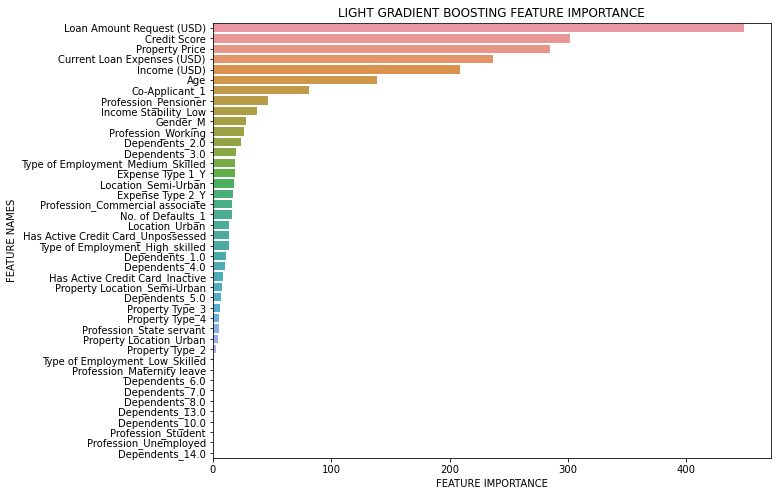

In [73]:
plot_feature_importance(clf_final.feature_importances_, X_train.columns, 'LIGHT GRADIENT BOOSTING')

##### Predicting the target based on Validaiton set

In [74]:
predictions = clf_final.predict(X_valid)
print(predictions)

[-1.09070912e+02  5.07837429e+04  8.30531342e+04 ...  4.84317867e+04
  2.73159020e+03  1.53885096e+05]


##### Lets check the R2-score on validation set

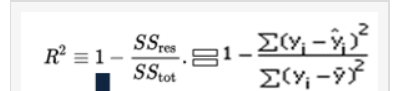

In [75]:
score = max(0,100*r2_score(y_valid, predictions))
print('r2_Score on validaiton set: ',score)

r2_Score on validaiton set:  79.76899648330891


##### Lets also check the Adjusted-R2 Score. The adjusted r2 score should not vary much.
##### It should be as close to r2 score as possible. It will indicate that the features are not much penalized

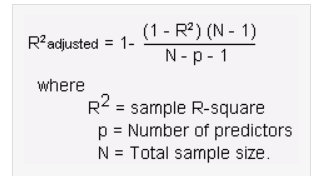

In [76]:
yhat = predictions
y = y_valid

SS_Residual = sum((y-yhat)**2)       
SS_Total = sum((y-np.mean(y))**2)     
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
print ('Adjusted r_squared score on validation set: ',adjusted_r_squared)

Adjusted r_squared score on validation set:  0.7962635721057149


##### The difference in r2-score and adj-r2 score is quite small (0.14) which is good

### Lets predict the test set !!

In [77]:
predictions_test = clf_final.predict(test)
predictions_test

array([91061.47690592, 62722.07436578, -4661.26153704, ...,
       -2917.15359531, 68284.71815779, 72401.73041474])

In [78]:
# generating the submission file in csv format

output = pd.DataFrame({'Customer ID': CustomerId, 'Loan Sanction Amount (USD)': predictions_test})
output.to_csv('my_submission2.csv',index = False)